In [2]:
import shutil, requests, os, glob
import subprocess
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.pyplot as plt
import shapely
import contextily as ctx

## Download vessel activity data for first 20 days at around 0AM

In [12]:
local_dir = '/Volumes/LuMas2324/OHW23_data/california-pam/'
def download_file(url):
    local_filename = os.path.join(local_dir,url.split('/')[-1])
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    return local_filename

In [8]:
# download vessel data for first 20 days
days = [f'{day:02d}' for day in range(1, 21)]
print(days)
urls = [f"https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_{day}.zip" for day in days]

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [5]:
print(urls)

['https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_01.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_02.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_03.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_04.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_05.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_06.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_07.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_08.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_09.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_10.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_11.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_12.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_13.zip'

In [9]:
for url in urls:
    download_file(url)

In [19]:
# unzip files
for file in glob.glob(local_dir + '/AIS_2021*.zip'):
    subprocess.Popen(['unzip', file, '-d', local_dir + 'vessel'])

Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_09.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_10.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_11.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_02.zip
  inflating: /Volumes/LuMas2324/OHW23_data/california-pam/vessel/AIS_2021_01_10.csv    inflating: /Volumes/LuMas2324/OHW23_data/california-pam/vessel/AIS_2021_01_09.csv  Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_12.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_01.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_03.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_04.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_05.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_06.zip
Archive:  /Volumes/LuMas2324/OHW23_data/california-pam/AIS_2021_01_07.zip
Archive:  /Volum

In [20]:
! pip install geopandas fiona shapely

In [25]:
! pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 5.8 MB/s eta 0:00:00m eta 0:00:010:00:01


# Read files

Attempt to count vessel activity within area at around 0AM

In [21]:
lat = 36.713
lon = -122.186

In [58]:
# develop function to output number of ships
def get_vessel_activity(data_path):
    # data path has date, so we can keep track of time
    date = os.path.basename(data_path)[4:-4]
    
    df = pd.read_csv(data_path, engine='pyarrow')
    query_time = df[df['BaseDateTime'].dt.hour == 13]
    query_boundingbox = f"LAT > {lat-0.25} & LAT < {lat + 0.25} & LON > {lon-0.25} & LON < {lon+0.25}"
    res = query_time.query(query_boundingbox)
    print(f"{date} has {len(res)} within bounding box")
    return res

In [59]:
results = {}
for f in glob.glob(local_dir + '/vessel/AIS*.csv'):
    res =get_vessel_activity(f)
    results[f] = res

2021_01_09 has 43 within bounding box
2021_01_02 has 1 within bounding box
2021_01_11 has 121 within bounding box
2021_01_12 has 23 within bounding box
2021_01_15 has 5 within bounding box
2021_01_13 has 28 within bounding box
2021_01_14 has 0 within bounding box
2021_01_17 has 0 within bounding box
2021_01_16 has 0 within bounding box
2021_01_18 has 0 within bounding box
2021_01_08 has 0 within bounding box
2021_01_05 has 51 within bounding box
2021_01_06 has 7 within bounding box
2021_01_03 has 2 within bounding box
2021_01_07 has 0 within bounding box
2021_01_19 has 39 within bounding box
2021_01_04 has 0 within bounding box
2021_01_20 has 54 within bounding box
2021_01_01 has 37 within bounding box


In [60]:
for d, res in results.items():
    date = os.path.basename(d)[4:-4]
    unique_vessels = len(res['MMSI'].unique())
    print(f"{date} has {unique_vessels} vessels within bounding box")

2021_01_09 has 1 vessels within bounding box
2021_01_02 has 1 vessels within bounding box
2021_01_11 has 3 vessels within bounding box
2021_01_12 has 1 vessels within bounding box
2021_01_15 has 1 vessels within bounding box
2021_01_13 has 2 vessels within bounding box
2021_01_14 has 0 vessels within bounding box
2021_01_17 has 0 vessels within bounding box
2021_01_16 has 0 vessels within bounding box
2021_01_18 has 0 vessels within bounding box
2021_01_08 has 0 vessels within bounding box
2021_01_05 has 1 vessels within bounding box
2021_01_06 has 1 vessels within bounding box
2021_01_03 has 1 vessels within bounding box
2021_01_07 has 0 vessels within bounding box
2021_01_19 has 2 vessels within bounding box
2021_01_04 has 0 vessels within bounding box
2021_01_20 has 2 vessels within bounding box
2021_01_01 has 1 vessels within bounding box


In [62]:
results[local_dir+'/vessel/AIS_2021_01_01.csv'].sort_values('BaseDateTime')

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
2994055,367528290,2021-01-01 13:02:33,36.95813,-122.00139,7.7,190.2,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3050911,367528290,2021-01-01 13:06:01,36.95054,-122.00596,9.2,213.8,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
6221987,367528290,2021-01-01 13:08:01,36.94728,-122.01049,8.6,252.0,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3046747,367528290,2021-01-01 13:09:33,36.94582,-122.01540,9.6,249.2,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3052338,367528290,2021-01-01 13:11:02,36.94447,-122.02015,9.5,251.7,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3154690,367528290,2021-01-01 13:12:32,36.94303,-122.02493,9.5,251.8,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3090710,367528290,2021-01-01 13:15:01,36.94067,-122.03288,9.9,250.8,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3169913,367528290,2021-01-01 13:16:32,36.93923,-122.03764,10.4,246.5,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3106447,367528290,2021-01-01 13:18:33,36.93728,-122.04410,9.2,251.3,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3113255,367528290,2021-01-01 13:20:01,36.93597,-122.04860,9.4,250.3,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B


In [63]:
results

{'/Volumes/LuMas2324/OHW23_data/california-pam//vessel/AIS_2021_01_09.csv':               MMSI        BaseDateTime       LAT        LON   SOG    COG  \
 3457827  367528290 2021-01-09 13:03:43  36.93324 -122.18364  11.7  279.8   
 3480535  367528290 2021-01-09 13:06:14  36.93339 -122.19302  11.7  269.6   
 3493044  367528290 2021-01-09 13:08:45  36.93337 -122.20243  10.8  269.0   
 3510310  367528290 2021-01-09 13:11:43  36.93316 -122.21353  11.1  268.7   
 3510399  367528290 2021-01-09 13:12:44  36.93310 -122.21725  11.5  269.1   
 3510418  367528290 2021-01-09 13:02:14  36.93310 -122.17813   9.9  269.4   
 3525622  367528290 2021-01-09 13:15:15  36.93296 -122.22660   9.7  269.0   
 3531304  367528290 2021-01-09 13:20:43  36.93268 -122.24698  10.8  271.9   
 3542114  367528290 2021-01-09 13:19:15  36.93272 -122.24145  11.1  272.6   
 3544657  367528290 2021-01-09 13:10:14  36.93328 -122.20799  10.0  267.4   
 3552247  367528290 2021-01-09 13:25:14  36.93240 -122.26378  11.3  265.5   
 

## Visualising a few hours of one day of vessel (2021_01_01)

In [64]:
lat = 36.713
lon = -122.186
data_path = local_dir + 'vessel/AIS_2021_01_01.csv'

In [66]:
df = pd.read_csv(data_path, engine='pyarrow')
query_time = df[df['BaseDateTime'].dt.hour == 13]
query_boundingbox = f"LAT > {lat-0.25} & LAT < {lat + 0.25} & LON > {lon-0.25} & LON < {lon+0.25}"
res = query_time.query(query_boundingbox)

In [67]:
res


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
2994055,367528290,2021-01-01 13:02:33,36.95813,-122.00139,7.7,190.2,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3046747,367528290,2021-01-01 13:09:33,36.94582,-122.01540,9.6,249.2,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3050911,367528290,2021-01-01 13:06:01,36.95054,-122.00596,9.2,213.8,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3052338,367528290,2021-01-01 13:11:02,36.94447,-122.02015,9.5,251.7,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3077041,367528290,2021-01-01 13:21:31,36.93451,-122.05346,9.9,253.1,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3080058,367528290,2021-01-01 13:22:33,36.93357,-122.05670,9.5,250.3,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3090681,367528290,2021-01-01 13:25:31,36.93122,-122.06631,9.0,269.3,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3090710,367528290,2021-01-01 13:15:01,36.94067,-122.03288,9.9,250.8,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3106447,367528290,2021-01-01 13:18:33,36.93728,-122.04410,9.2,251.3,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B
3113243,367528290,2021-01-01 13:27:02,36.93087,-122.07144,10.8,262.6,511.0,RUTH ANNE II,,WDG3653,30.0,NaN,10.0,NaN,NaN,NaN,B


## Visualizing vessel movement

In [82]:
def plot_movement(k):
    key = local_dir + f'/vessel/AIS_{k}.csv'
    distinct_mmsis = results[key]['MMSI'].unique()
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['red', 'blue']
    color_count = 0
    for mmsi in distinct_mmsis:
        df = results[key].query(f"MMSI=={mmsi}")
        gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df['LON'], df['LAT']))
        geo_df = gdf['geometry']
        geo_df.crs={'init': "epsg:4326"}

        ax = geo_df.plot(ax=ax, markersize=20, marker='o', color=colors[color_count], label=f'MMSI={mmsi}')
        color_count +=1
        
    ax.plot([lon], [lat], marker='*', color='black', markersize=30, label='MARS point')
    ax.set_xlim(extent[0]-0.25, extent[1]+0.25)
    ax.set_ylim(extent[2]-0.25, extent[3]+0.25)
    ctx.add_basemap(ax, crs=geo_df.crs, source = ctx.providers.Stamen.TonerLite)
    ax.legend(loc='upper right', labelspacing=2)

/Users/lucillechapuis/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/lucillechapuis/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


NameError: name 'extent' is not defined

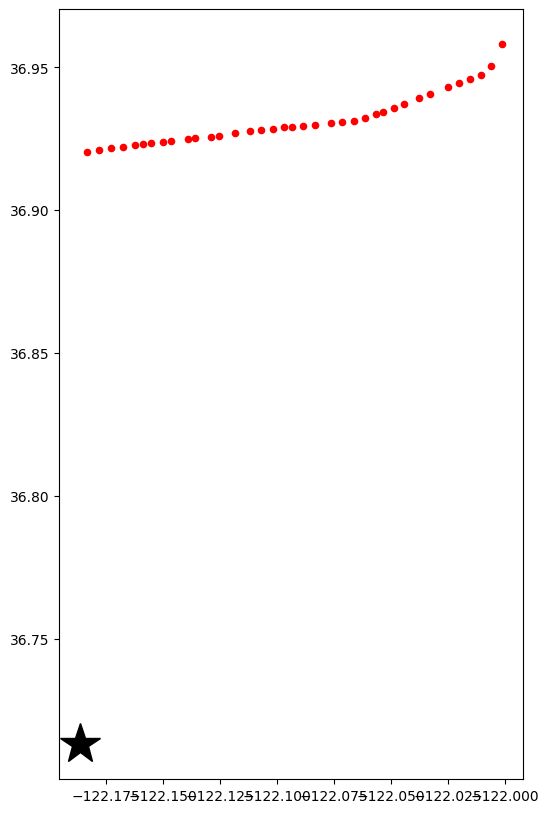

In [83]:
plot_movement('2021_01_01')

NameError: name 'gdf' is not defined

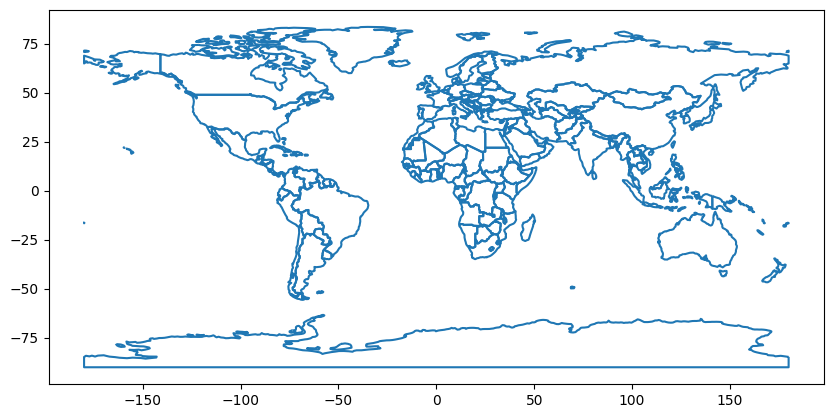

In [80]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 6))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, marker='o', color='blue', markersize=50)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

In [81]:
geo_df = gdf['geometry']
geo_df.crs={'init': "epsg:4326"}

fig, ax = plt.subplots(figsize=(10, 10))
ax = geo_df.plot(ax=ax, markersize=20, marker='o')
ax.set_xlim(extent[0]-0.25, extent[1]+0.25)
ax.set_ylim(extent[2]-0.25, extent[3]+0.25)
ax.plot([lon], [lat], marker='*', color='white', markersize=30)
ctx.add_basemap(ax, crs=geo_df.crs, source = ctx.providers.Stamen.TonerLite)


NameError: name 'gdf' is not defined

In [52]:
type(ax)

matplotlib.axes._axes.Axes